#### Implement text classification using word2vec and LSTM

In [5]:
import numpy as np 
import pandas as pd 


In [6]:
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam



In [7]:
data=pd.read_csv('../Dataset/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [9]:
data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [10]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/vicky_gupta/nltk_data...


True

In [11]:
data['review'] = data['review'].apply(lambda x: x.replace('<br />', '').replace('\n', '').replace('\'', ''))

In [12]:
data['review'] = data['review'].apply(lambda x: re.sub('[^a-zA-z\s]','',x))

In [13]:
data['review'] = data['review'].apply(lambda x:x.lower())

In [14]:
stop_words = set(stopwords.words("english"))
data['review'] = data['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [15]:
data['review']  = data['review'].apply(lambda x: ' '.join([lemma.lemmatize(word) for word in x.split()]))

In [16]:
data['review'][1]

'wonderful little production filming technique unassuming oldtimebbc fashion give comforting sometimes discomforting sense realism entire piece actor extremely well chosen michael sheen got polari voice pat truly see seamless editing guided reference williams diary entry well worth watching terrificly written performed piece masterful production one great master comedy life realism really come home little thing fantasy guard rather use traditional dream technique remains solid disappears play knowledge sens particularly scene concerning orton halliwell set particularly flat halliwells mural decorating every surface terribly well done'

In [17]:
data.head()

,review,sentiment
0,one reviewer mentioned watching oz episode you...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically there family little boy jake think t...,negative
4,petter matteis love time money visually stunni...,positive


In [20]:
reviews = data['review'].values
labels = data['sentiment'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(reviews, encoded_labels,test_size = 0.25)

In [22]:
X_train.shape, X_test.shape

((37500,), (12500,))

In [23]:
vocab_size = 3000
oov_tok = ''
embedding_dim = 100
max_length = 200
trunc_type = 'post'
padding_type = 'post'


In [24]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [25]:
X_train = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train, padding='post', maxlen=max_length)

In [26]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test, padding='post', maxlen=max_length)

In [27]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(128)))
#model.add(LSTM(128))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          300000    
                                                                 
 bidirectional (Bidirection  (None, 256)               234496    
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 551009 (2.10 MB)
Trainable params: 551009 (2.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [29]:
history = model.fit(X_train_padded, y_train, epochs=5, verbose=1,steps_per_epoch = len(X_train)/256,batch_size = 256,validation_split=0.1)

Epoch 1/5
146/146 [==============================] - 75s 504ms/step - loss: 0.4746 - accuracy: 0.7555 - val_loss: 0.3434 - val_accuracy: 0.8749
Epoch 2/5
146/146 [==============================] - 85s 582ms/step - loss: 0.2856 - accuracy: 0.8857 - val_loss: 0.3274 - val_accuracy: 0.8619
Epoch 3/5
146/146 [==============================] - 87s 595ms/step - loss: 0.2569 - accuracy: 0.8993 - val_loss: 0.3242 - val_accuracy: 0.8704
Epoch 4/5
146/146 [==============================] - 89s 608ms/step - loss: 0.2313 - accuracy: 0.9092 - val_loss: 0.3146 - val_accuracy: 0.8731
Epoch 5/5
146/146 [==============================] - 43s 293ms/step - loss: 0.2271 - accuracy: 0.9088 - val_loss: 0.3195 - val_accuracy: 0.8720


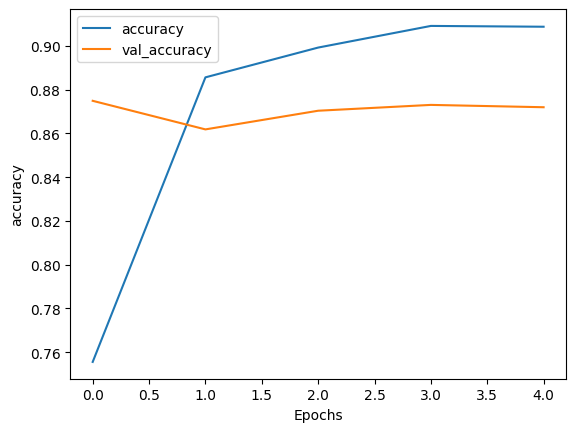

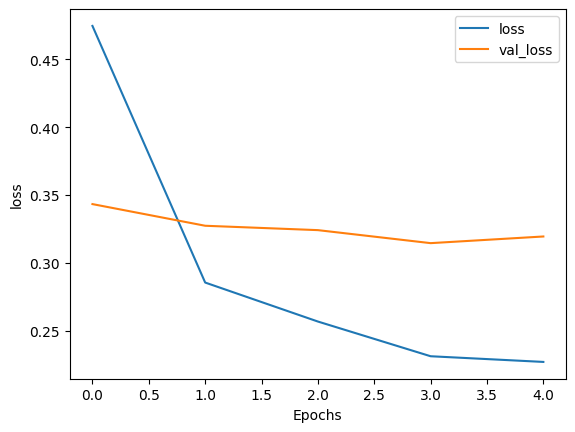

In [30]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [31]:
from sklearn.metrics import accuracy_score
prediction = model.predict(X_test_padded)
# Get labels based on probability 1 if p>= 0.5 else 0
y_pred = []
for i in prediction:
    if i >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(y_test,y_pred))

391/391 [==============================] - 21s 54ms/step
Accuracy of prediction on test set :  0.86512
